In [1]:
!pip install statsmodels

In [2]:
!pip install pmdarima

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm


### Box Jenkins Method (details):

1. Apply transformations to make time series stationary (detrending, transformations, differencing).
2. If differencing, keep track of order d of differencing. Don't overdifference!
3. Confirm stationarity (visually, ACF, ADF test)
4. Plot ACF/PACF, identify likely AR and MA orders p, q.
5. Fit original (non-differenced) data with ARIMA model of order p, d, q
6. Try a few other values around these orders
7. Of all models with similarly low AIC, pick the least complex one
8. Inspect residuals: If ACF and PACF show white noise (no signal left)➔ You are done.
9. Otherwise ➔ Iterate (Try other transformations, change order of differencing, Add/Remove MA/AR terms)
10. Compare with Auto-ARIMA output trace


In [4]:
# Reading Data
data = pd.read_excel('../raw_data/daily_data_clean.xlsx', engine='openpyxl')

In [5]:
data

,Unnamed: 0,date_issue,total_amount_claims
0,0,2018-09-01,168
1,1,2018-09-02,346
2,2,2018-09-03,16169
3,3,2018-09-04,28529
4,4,2018-09-05,64135
...,...,...,...
915,915,2021-03-04,350720
916,916,2021-03-05,293427
917,917,2021-03-06,333658
918,918,2021-03-07,139824


In [6]:
# Dropping extra index column
data = data.drop(columns= 'Unnamed: 0')

In [7]:
data.isnull().sum()

date_issue             0
total_amount_claims    0
dtype: int64

In [8]:
# Check types and lenght
data.dtypes, len(data)

(date_issue             datetime64[ns]
 total_amount_claims             int64
 dtype: object,
 920)

<AxesSubplot:xlabel='date_issue'>

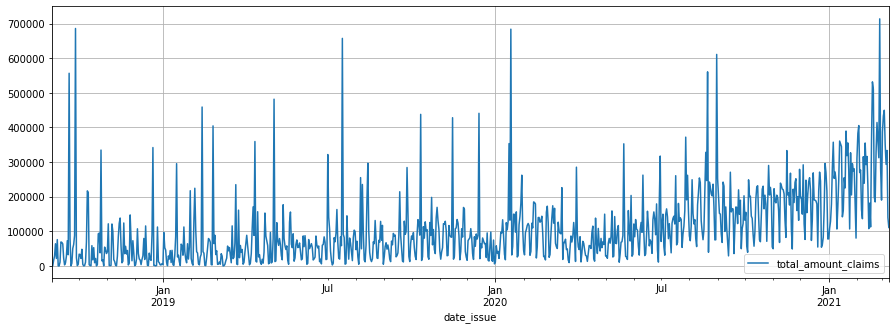

In [9]:
# Setting index as date, to plot time series
data_di = data.set_index('date_issue')

#Plotting
data_di.plot(grid=True, figsize=(15,5))

In [10]:
data_di.head()

,total_amount_claims
date_issue,
2018-09-01,168
2018-09-02,346
2018-09-03,16169
2018-09-04,28529
2018-09-05,64135


#### 1. Apply transformations to make time series stationary (detrending, transformations, differencing).

<AxesSubplot:xlabel='date_issue'>

<Figure size 1440x720 with 0 Axes>

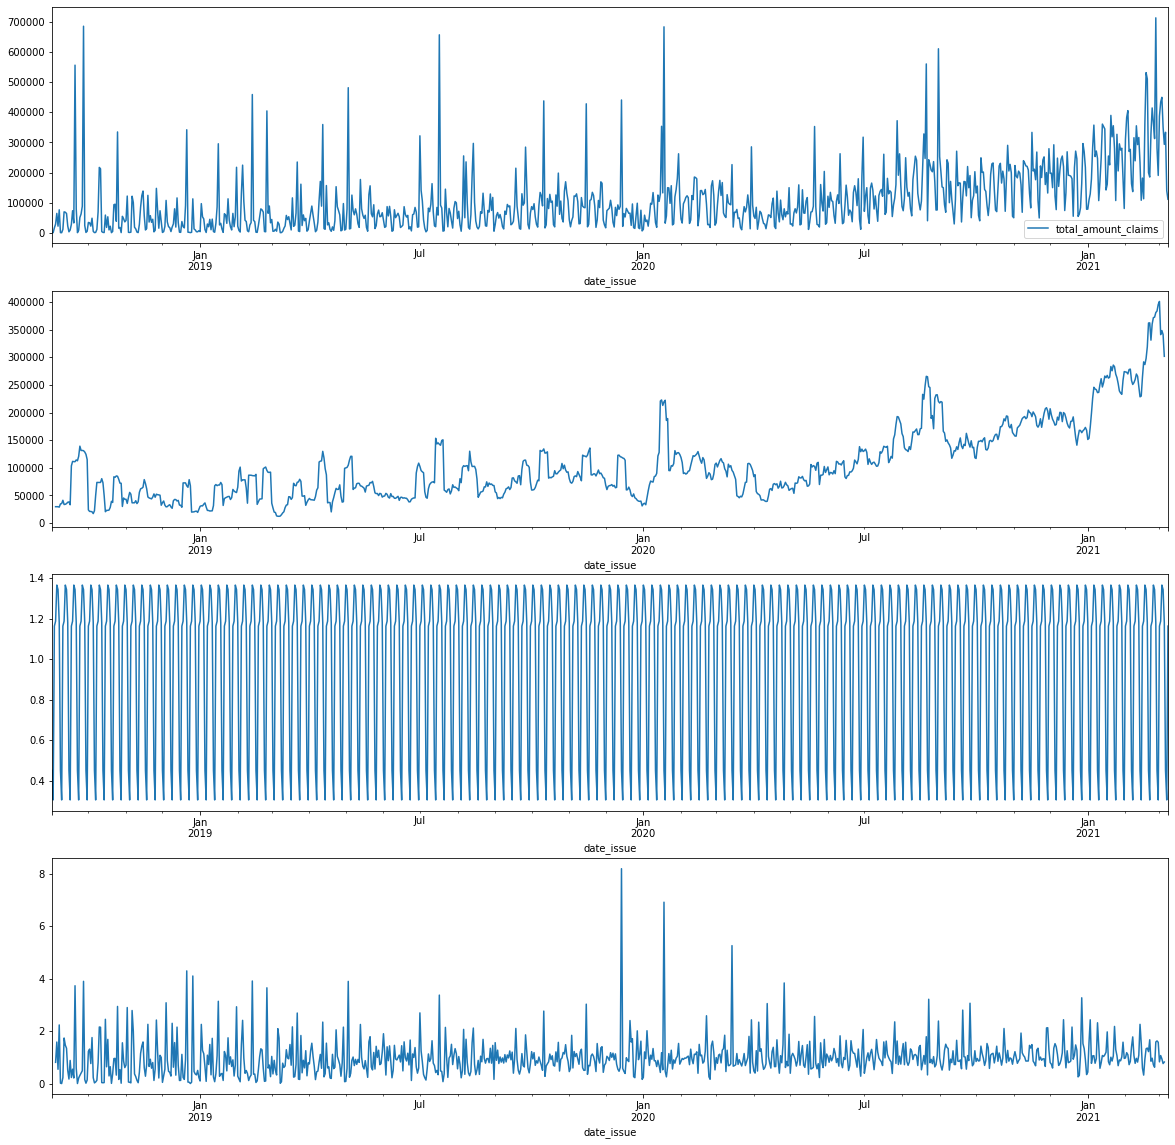

In [11]:
# Applying seasonal decompose

#First we try multiplicative
res_mul = seasonal_decompose(data_di, model='multiplicative')
plt.figure(figsize=(20,10))

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(20,20))
data_di.plot(ax=ax1)
res_mul.trend.plot(ax=ax2)
res_mul.seasonal.plot(ax=ax3)
res_mul.resid.plot(ax=ax4)



<AxesSubplot:xlabel='date_issue'>

<Figure size 1440x720 with 0 Axes>

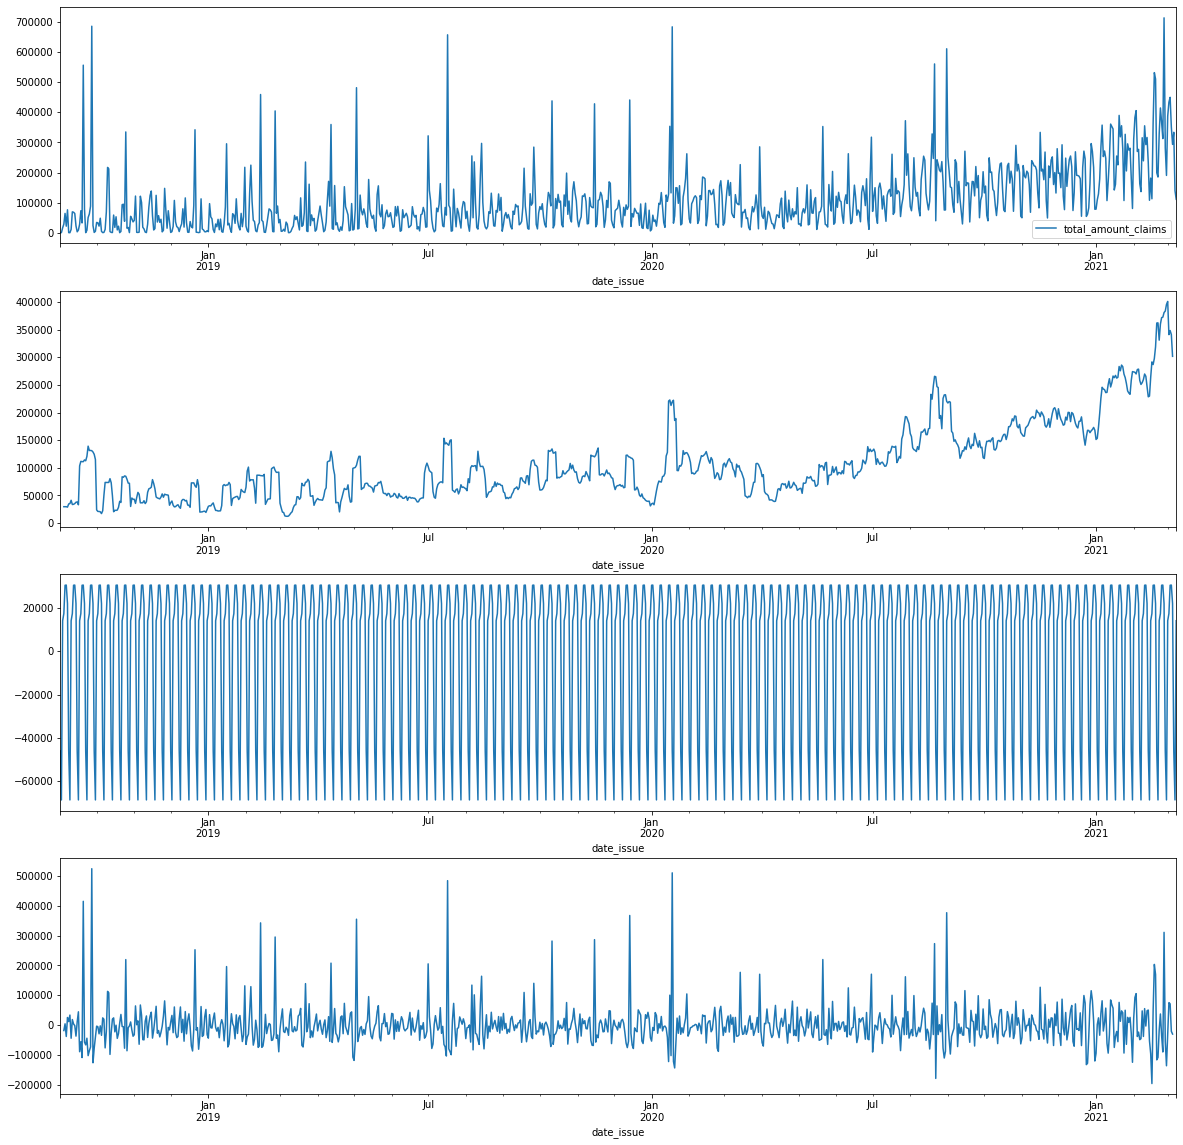

In [12]:
# Now we try additive
res_add = seasonal_decompose(data_di, model='additive')
plt.figure(figsize=(20,10))

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(20,20))
data_di.plot(ax=ax1)
res_add.trend.plot(ax=ax2)
res_add.seasonal.plot(ax=ax3)
res_add.resid.plot(ax=ax4)


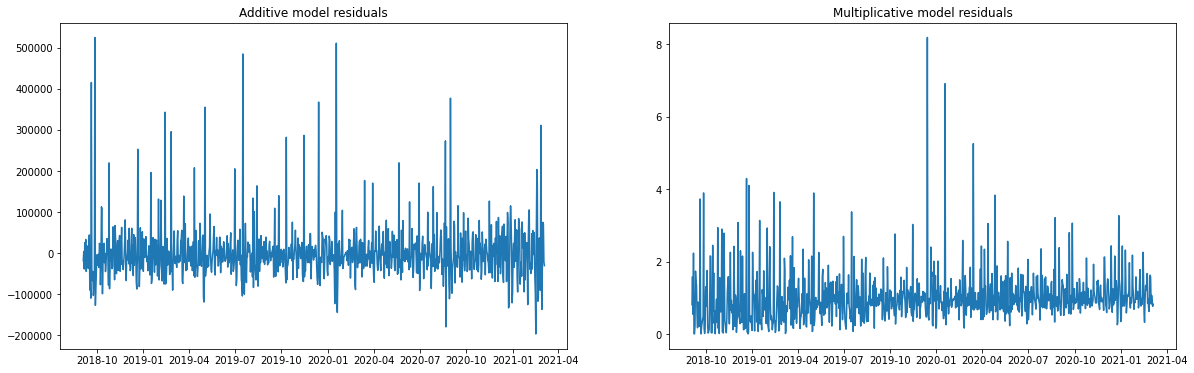

In [13]:
# Plot the residuals with "result_add.resid" to decide
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.plot(res_add.resid); ax1.set_title("Additive model residuals")
ax2.plot(res_mul.resid); ax2.set_title("Multiplicative model residuals");

# Multiplicative seems better (residuals less dependent from time)

In [14]:
res_add.resid.isnull().sum()

6

In [15]:
# Checking stationarity in original data

pvalue_y = adfuller(data_di)[1]
pvalue_y
def stationary(pvalue):
    if pvalue < 0.05:
        print('TS is stationary')
    else:
        print('TS is not stationary')
stationary(pvalue_y), pvalue_y


TS is not stationary


(None, 0.949805943652062)

In [16]:
# Checking stationarity in multiplicative decomposed serie
mul_resid_ts = res_mul.resid.dropna()
pvalue_y_mul = adfuller(mul_resid_ts)[1]
stationary(pvalue_y_mul), pvalue_y_mul

TS is stationary


(None, 0.004511228740169238)

In [17]:
# Checking stationarity in additive decomposed serie
add_resid_ts = res_add.resid.dropna()
pvalue_y_add = adfuller(add_resid_ts)[1]
stationary(pvalue_y_add), pvalue_y_add

TS is stationary


(None, 1.6703293475457954e-23)

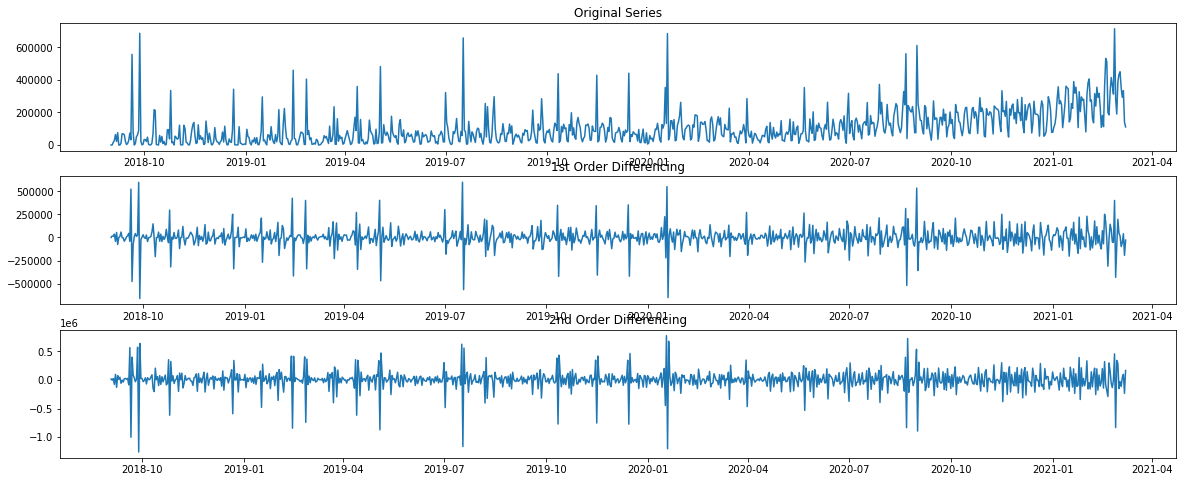

In [18]:
# Differencing original series (exploring)

data_di_diff_1 = data_di.diff(1).dropna()
data_di_diff_2 = data_di.diff(1).diff(1).dropna()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,8))
ax1.plot(data_di); ax1.set_title('Original Series')
ax2.plot(data_di_diff_1); ax2.set_title('1st Order Differencing')
ax3.plot(data_di_diff_2); ax3.set_title('2nd Order Differencing');

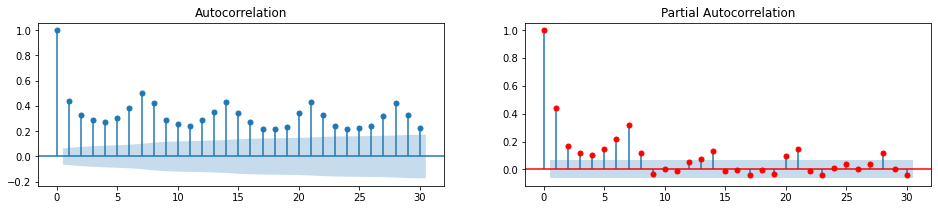

In [19]:
## ACF y PACF of original serie
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(data_di, lags=30, ax=axes[0]);
plot_pacf(data_di, lags=30, ax=axes[1], color='r');

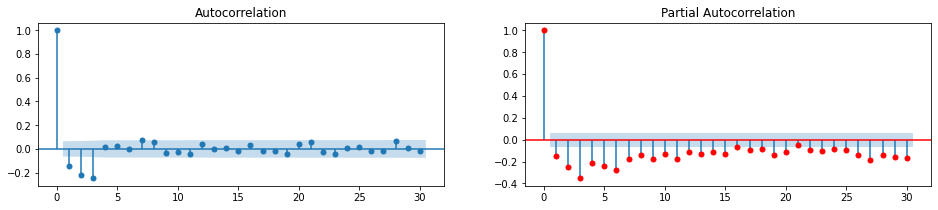

In [20]:
# Checking additive residuals ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(add_resid_ts, lags=30, ax=axes[0]);
plot_pacf(add_resid_ts, lags=30, ax=axes[1], color='r');

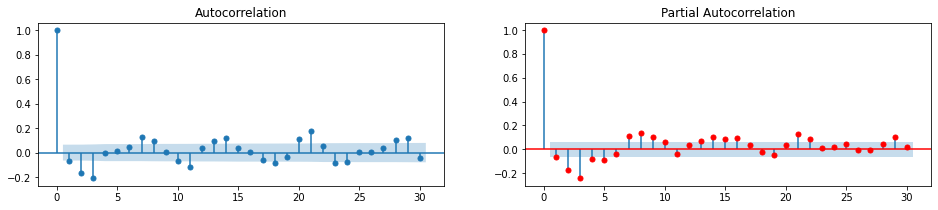

In [21]:
# Checking multiplicative residuals ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(mul_resid_ts, lags=30, ax=axes[0]);
plot_pacf(mul_resid_ts, lags=30, ax=axes[1], color='r');

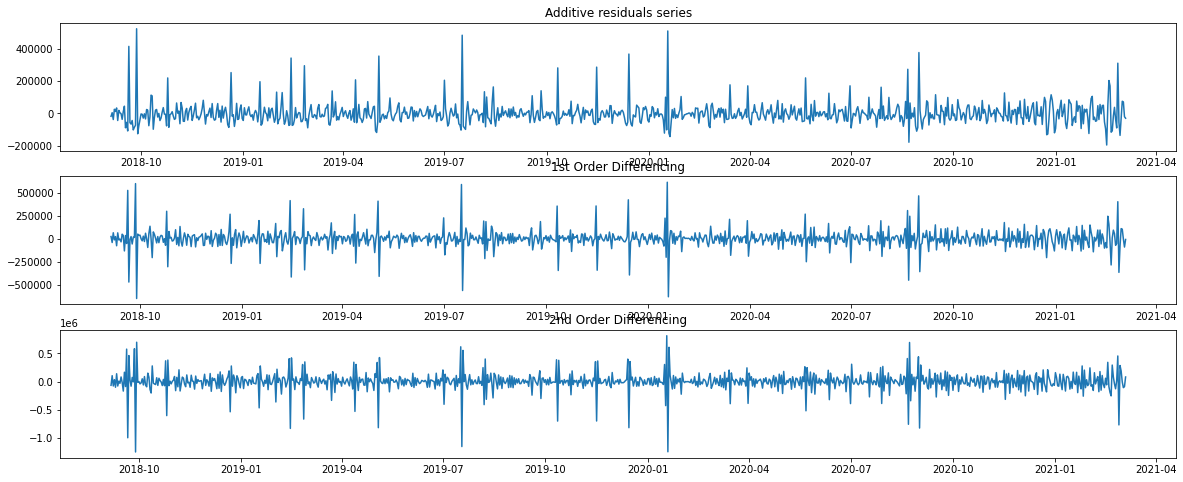

In [22]:
# Differencing additive residuals series
add_resid_ts_diff_1 = add_resid_ts.diff(1).dropna()
add_resid_ts_diff_2 = add_resid_ts.diff(1).diff(1).dropna()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,8))
ax1.plot(add_resid_ts); ax1.set_title('Additive residuals series')
ax2.plot(add_resid_ts_diff_1); ax2.set_title('1st Order Differencing')
ax3.plot(add_resid_ts_diff_2); ax3.set_title('2nd Order Differencing');

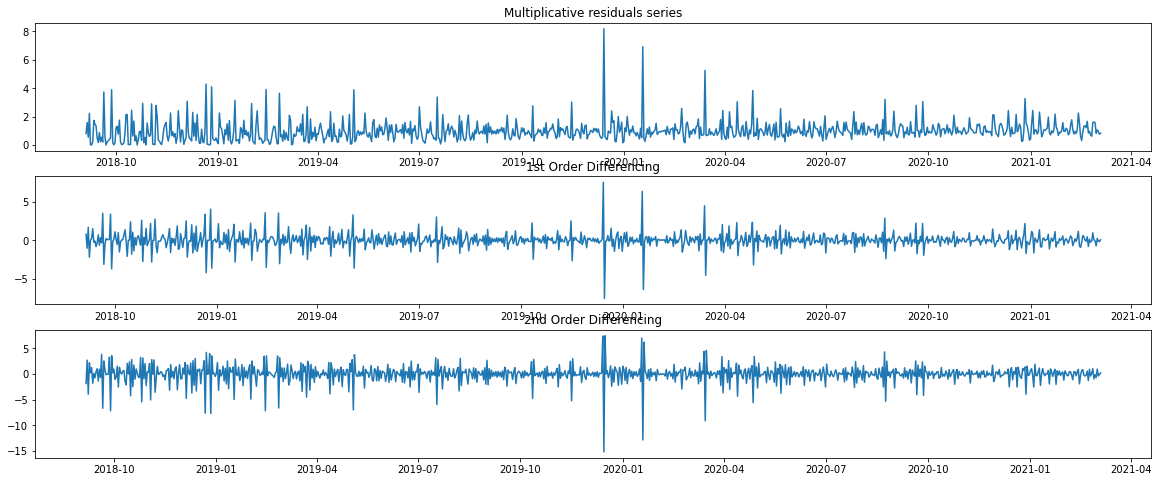

In [23]:
# Differencing multiplicative residuals series
mul_resid_ts_diff_1 = mul_resid_ts.diff(1).dropna()
mul_resid_ts_diff_2 = mul_resid_ts.diff(1).diff(1).dropna()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,8))
ax1.plot(mul_resid_ts); ax1.set_title('Multiplicative residuals series')
ax2.plot(mul_resid_ts_diff_1); ax2.set_title('1st Order Differencing')
ax3.plot(mul_resid_ts_diff_2); ax3.set_title('2nd Order Differencing');

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


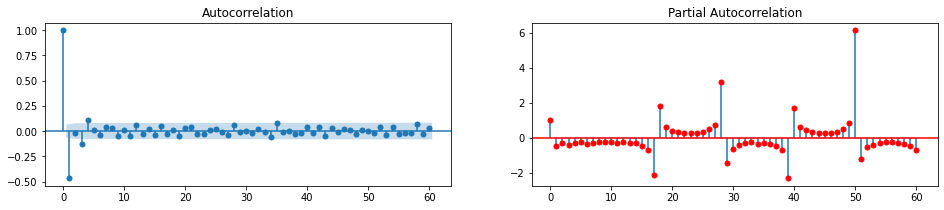

In [24]:
# Checking additive residuals diff 1 ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(add_resid_ts_diff_1, lags=60, ax=axes[0]);
plot_pacf(add_resid_ts_diff_1, lags=60, ax=axes[1], color='r');

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


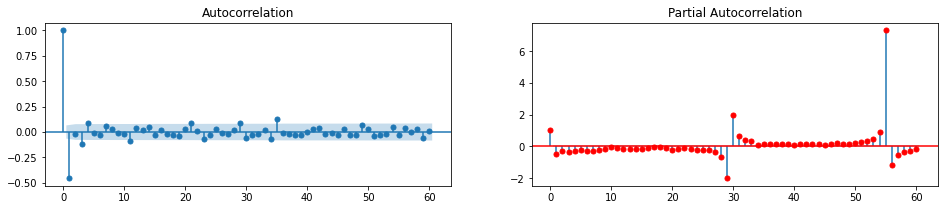

In [25]:
# Checking multiplicative residuals diff 1 ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(mul_resid_ts_diff_1, lags=60, ax=axes[0]);
plot_pacf(mul_resid_ts_diff_1, lags=60, ax=axes[1], color='r');

In [61]:
# Splitting data
# Additive serie
split_1 = 0.7
split_index_1 = round(len(add_resid_ts)*split_1)

add_resid_ts_train = add_resid_ts.iloc[:split_index_1]
add_resid_ts_test = add_resid_ts.iloc[split_index_1:]

add_resid_ts_train.head(), add_resid_ts_train.tail(), add_resid_ts_test.head(), add_resid_ts_test.tail()


(date_issue
 2018-09-04   -18469.011750
 2018-09-05     4061.161642
 2018-09-06   -38382.415240
 2018-09-07    25273.796320
 2018-09-08    11534.223742
 Name: resid, dtype: float64,
 date_issue
 2020-05-31     5223.978687
 2020-06-01     5574.123742
 2020-06-02   -20385.011750
 2020-06-03    12170.590213
 2020-06-04   -15251.843811
 Name: resid, dtype: float64,
 date_issue
 2020-06-05    -7254.060823
 2020-06-06     8491.080885
 2020-06-07    10508.407258
 2020-06-08   -21378.019115
 2020-06-09    -2359.440321
 Name: resid, dtype: float64,
 date_issue
 2021-03-01   -27823.304829
 2021-03-02    75100.559679
 2021-03-03    70963.590213
 2021-03-04   -20985.129525
 2021-03-05   -30308.632252
 Name: resid, dtype: float64)

In [62]:
# Splitting data
# Multiplicative serie

split_2 = 0.7
split_index_2 = round(len(mul_resid_ts)*split_2)
mul_resid_ts_train = mul_resid_ts.iloc[:split_index_2]
mul_resid_ts_test = mul_resid_ts.iloc[split_index_2:]

mul_resid_ts_train.head(), mul_resid_ts_train.tail(), mul_resid_ts_test.head(), mul_resid_ts_test.tail()

(date_issue
 2018-09-04    0.811052
 2018-09-05    1.585020
 2018-09-06    0.546783
 2018-09-07    2.236143
 2018-09-08    0.016637
 Name: resid, dtype: float64,
 date_issue
 2020-05-31    1.127712
 2020-06-01    1.025453
 2020-06-02    0.812688
 2020-06-03    1.073002
 2020-06-04    0.868956
 Name: resid, dtype: float64,
 date_issue
 2020-06-05    0.987657
 2020-06-06    1.340443
 2020-06-07    1.146641
 2020-06-08    0.803077
 2020-06-09    0.955869
 Name: resid, dtype: float64,
 date_issue
 2021-03-01    0.829761
 2021-03-02    1.069768
 2021-03-03    0.944894
 2021-03-04    0.765003
 2021-03-05    0.823500
 Name: resid, dtype: float64)

In [63]:
# Trying Auto ARIMA with additive residuals serie
stepwise_fit_add = pm.auto_arima(add_resid_ts_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_add.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=16849.608, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=16535.518, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=16676.957, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=16466.309, Time=0.26 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=16391.536, Time=0.59 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(2,1,2)[7]             : AIC=16392.816, Time=0.81 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=0.45 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=16325.744, Time=0.60 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=16323.960, Time=0.29 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=16321.996, Time=0.18 sec
 ARIMA(2,1,0)(0,1,0)[7]             : AIC=16608.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  640
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -8156.998
Date:                             Wed, 10 Mar 2021   AIC                          16321.996
Time:                                     14:55:25   BIC                          16339.792
Sample:                                          0   HQIC                         16328.908
                                             - 640                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6469      0.047    -13.755      0.000      -0.739      -0.555
ar.L2         -0.3201      0.053     -6.049      0.000      -0.424      -0.216
ma.S.L7       -0.9317      0.035    -26.394      0.000      -1.001      -0.863
sigma2      1.506e+10   3.35e-13   4.49e+22      0.000    1.51e+10    1.51e+10
===================================================================================
Ljung-Box (L1) (Q):                  11.35   Jarque-Bera (JB):              3166.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             2.01
Prob(H) (two-sided):                  0.03   Kurtosis:                        13.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.33e+38. Standard errors may be unstable.
"""

In [64]:

# Trying Auto ARIMA with multiplicative residuals serie
stepwise_fit_mul = pm.auto_arima(mul_resid_ts_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_mul.summary()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=2400.696, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=2072.662, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.66 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=2238.080, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=1960.106, Time=0.13 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=1842.660, Time=0.50 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=1843.687, Time=0.17 sec
 ARIMA(1,1,0)(2,1,2)[7]             : AIC=1835.112, Time=0.93 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=inf, Time=0.92 sec
 ARIMA(2,1,0)(2,1,2)[7]             : AIC=1769.693, Time=0.97 sec
 ARIMA(2,1,0)(1,1,2)[7]             : AIC=1773.329, Time=1.24 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=1775.696, Time=0.61 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=1774.801, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  640
Model:             SARIMAX(2, 1, 0)x(2, 1, [1, 2], 7)   Log Likelihood                -877.847
Date:                                Wed, 10 Mar 2021   AIC                           1769.693
Time:                                        14:55:40   BIC                           1800.835
Sample:                                             0   HQIC                          1781.788
                                                - 640                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6643      0.026    -25.658      0.000      -0.715      -0.614
ar.L2         -0.3196      0.026    -12.270      0.000      -0.371      -0.269
ar.S.L7       -0.8587      0.108     -7.970      0.000      -1.070      -0.648
ar.S.L14      -0.1125      0.043     -2.632      0.009      -0.196      -0.029
ma.S.L7       -0.0806      0.106     -0.762      0.446      -0.288       0.127
ma.S.L14      -0.7346      0.104     -7.068      0.000      -0.938      -0.531
sigma2         0.9219      0.022     42.499      0.000       0.879       0.964
===================================================================================
Ljung-Box (L1) (Q):                  10.22   Jarque-Bera (JB):              3570.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             1.91
Prob(H) (two-sided):                  0.74   Kurtosis:                        14.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
# with m=12 AIC = 1954.975, Best Model = ARIMA(2,1,0)(2,1,0)[12] 
# with m=7 AIC =  1769.693, Best Model = ARIMA(2,1,0)(2,1,2)[7]
# with m=1 AIC = 1804.360, Best Model = ARIMA(2,1,0)(0,0,0)[0] 



In [66]:
# We are choosing multiplicative decomposed serie with m=7 because it gives the lower AIC
# Let's predict


resid_pred_mul = stepwise_fit_mul.predict(n_periods=len(mul_resid_ts_test))

In [67]:
resid_pred_mul

array([1.13919751, 1.11840492, 1.27606378, 0.97050864, 0.86544842,
       0.75332616, 1.2085702 , 1.02948992, 1.22226646, 1.40317049,
       0.92692485, 0.95123492, 0.7721695 , 1.02392711, 1.16709744,
       1.05169137, 1.30388992, 0.96265997, 0.86787446, 0.79646857,
       1.14198463, 1.06085547, 1.18699994, 1.37414205, 0.93668367,
       0.92966499, 0.77314212, 1.0611516 , 1.13637031, 1.08972866,
       1.32473946, 0.95472064, 0.88572831, 0.79019112, 1.1170341 ,
       1.08322442, 1.15778711, 1.35900967, 0.94190365, 0.9162568 ,
       0.77792444, 1.07788913, 1.12011718, 1.11003547, 1.33488807,
       0.95063069, 0.89473344, 0.78629005, 1.10496739, 1.09416462,
       1.14313481, 1.35149657, 0.94432811, 0.90953168, 0.78023593,
       1.08586781, 1.11205039, 1.11983295, 1.33969765, 0.94850833,
       0.898995  , 0.78424346, 1.0989728 , 1.09936061, 1.13586923,
       1.34771113, 0.94537741, 0.9061282 , 0.78123288, 1.0896175 ,
       1.10799542, 1.12446947, 1.34190678, 0.94734553, 0.90093

In [68]:
pa = pd.DataFrame(mul_resid_ts_test)
pa['resid_pred_mul'] = resid_pred_mul
pa['absolute_error'] = abs(pa['resid'] - pa['resid_pred_mul'])
pa

,resid,resid_pred_mul,absolute_error
date_issue,,,
2020-06-05,0.987657,1.139198,0.151541
2020-06-06,1.340443,1.118405,0.222038
2020-06-07,1.146641,1.276064,0.129422
2020-06-08,0.803077,0.970509,0.167431
2020-06-09,0.955869,0.865448,0.090421
...,...,...,...
2021-03-01,0.829761,0.942930,0.113169
2021-03-02,1.069768,0.899464,0.170304
2021-03-03,0.944894,0.778736,0.166158


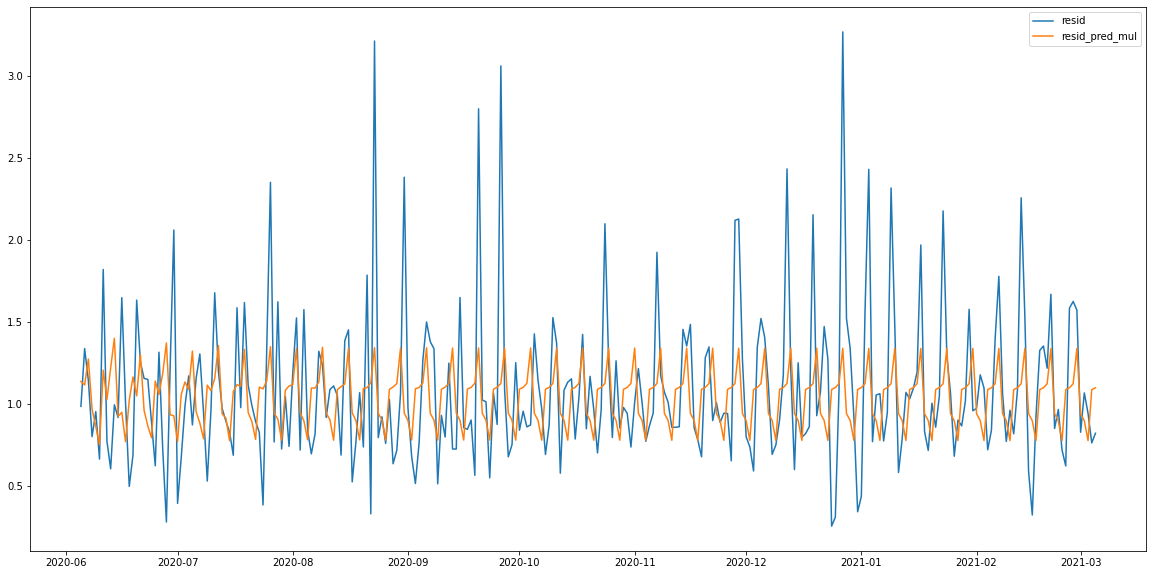

In [69]:
#Plotting residuals

plt.figure(figsize=(20,10))
plt.plot( 'resid', data= pa)
plt.plot( 'resid_pred_mul', data= pa)
plt.legend()

In [70]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [71]:
# Plot predict with optimal model
# Build model
best_sarima = SARIMAX(mul_resid_ts_train, order=(2, 1, 0),seasonal_order=(2,1,2,7))
best_sarima = best_sarima.fit()

# Forecast
best_results = best_sarima.get_forecast(len(mul_resid_ts_test), alpha=0.05)
best_forecast = best_results.predicted_mean
best_confidence_int = best_results.conf_int()

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [72]:
best_confidence_int

,lower resid,upper resid
2020-06-05,-0.742691,3.021086
2020-06-06,-0.866688,3.103498
2020-06-07,-0.887609,3.439736
2020-06-08,-1.460445,3.401462
2020-06-09,-1.716702,3.447599
...,...,...
2021-03-01,-44.244520,46.130381
2021-03-02,-44.487956,46.286883
2021-03-03,-44.808457,46.365930
2021-03-04,-44.696568,46.876024


In [73]:
# re-compose back to initial time series
best_forecast_recons = best_forecast*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
train_recons = mul_resid_ts_train*res_mul.seasonal[:split_index_2]*res_mul.trend[:split_index_2]
test_recons = mul_resid_ts_test*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
best_upper_recons = best_confidence_int['upper resid']*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
best_lower_recons = best_confidence_int['lower resid']*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]

In [74]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

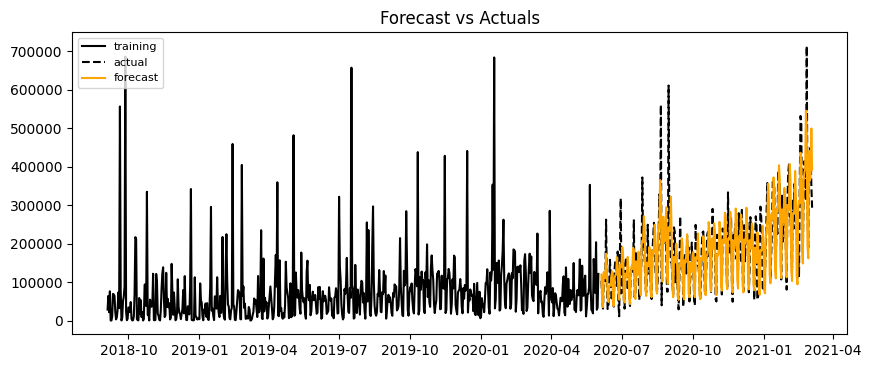

In [75]:
# Plotting 
plot_forecast(best_forecast_recons, train_recons, test_recons, upper = best_upper_recons, lower=best_lower_recons)


In [76]:
test_recons

date_issue
2020-06-02         NaN
2020-06-03         NaN
2020-06-04         NaN
2020-06-05    103524.0
2020-06-06     57229.0
                ...   
2021-03-04    350720.0
2021-03-05    293427.0
2021-03-06         NaN
2021-03-07         NaN
2021-03-08         NaN
Length: 280, dtype: float64

In [77]:
# computing mae
best_sarima_performance = pd.DataFrame(test_recons)
best_sarima_performance['best_forecast_recons'] = best_forecast_recons
best_sarima_performance.rename(columns={0: 'test_recons'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['test_recons'] - best_sarima_performance['best_forecast_recons'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()



51459.4382835535

### Changing Train/Test split to reduce prediction horizon.

In [155]:
# Splitting data
# Multiplicative serie

split_2 = 0.93
split_index_2 = round(len(mul_resid_ts)*split_2)
mul_resid_ts_train = mul_resid_ts.iloc[:split_index_2]
mul_resid_ts_test = mul_resid_ts.iloc[split_index_2:]

mul_resid_ts_train.head(), mul_resid_ts_train.tail(), mul_resid_ts_test.head(), mul_resid_ts_test.tail()

(date_issue
 2018-09-04    0.811052
 2018-09-05    1.585020
 2018-09-06    0.546783
 2018-09-07    2.236143
 2018-09-08    0.016637
 Name: resid, dtype: float64,
 date_issue
 2020-12-27    3.271307
 2020-12-28    1.524346
 2020-12-29    1.338752
 2020-12-30    0.918106
 2020-12-31    0.344891
 Name: resid, dtype: float64,
 date_issue
 2021-01-01    0.438329
 2021-01-02    1.576078
 2021-01-03    2.432896
 2021-01-04    0.772134
 2021-01-05    1.057029
 Name: resid, dtype: float64,
 date_issue
 2021-03-01    0.829761
 2021-03-02    1.069768
 2021-03-03    0.944894
 2021-03-04    0.765003
 2021-03-05    0.823500
 Name: resid, dtype: float64)

In [156]:
# Trying Auto ARIMA with multiplicative residuals serie
stepwise_fit_mul = pm.auto_arima(mul_resid_ts_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_mul.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=3047.611, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=2597.171, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.78 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=2825.437, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=2453.039, Time=0.19 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=2291.634, Time=0.68 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=2292.148, Time=0.28 sec
 ARIMA(1,1,0)(2,1,2)[7]             : AIC=2286.176, Time=1.02 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=1.08 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=inf, Time=1.05 sec
 ARIMA(2,1,0)(2,1,2)[7]             : AIC=2197.701, Time=0.99 sec
 ARIMA(2,1,0)(1,1,2)[7]             : AIC=2202.116, Time=1.53 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=2201.642, Time=0.62 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=2200.467, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  850
Model:             SARIMAX(2, 1, 0)x(2, 1, [1, 2], 7)   Log Likelihood               -1091.850
Date:                                Wed, 10 Mar 2021   AIC                           2197.701
Time:                                        15:05:04   BIC                           2230.851
Sample:                                             0   HQIC                          2210.405
                                                - 850                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6595      0.021    -31.132      0.000      -0.701      -0.618
ar.L2         -0.3210      0.021    -14.993      0.000      -0.363      -0.279
ar.S.L7       -0.8197      0.137     -5.994      0.000      -1.088      -0.552
ar.S.L14      -0.1022      0.034     -3.025      0.002      -0.168      -0.036
ma.S.L7       -0.1361      0.136     -0.999      0.318      -0.403       0.131
ma.S.L14      -0.6933      0.131     -5.299      0.000      -0.950      -0.437
sigma2         0.7705      0.015     51.646      0.000       0.741       0.800
===================================================================================
Ljung-Box (L1) (Q):                  13.50   Jarque-Bera (JB):              6054.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                             1.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [157]:
# Plot predict with optimal model
# Build model
best_sarima = SARIMAX(mul_resid_ts_train, order=(2, 1, 0),seasonal_order=(2,1,2,7))
best_sarima = best_sarima.fit()

# Forecast
best_results = best_sarima.get_forecast(len(mul_resid_ts_test), alpha=0.05)
best_forecast = best_results.predicted_meqdan
best_confidence_int = best_results.conf_int()

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [158]:
# re-compose back to initial time series
best_forecast_recons = best_forecast*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
train_recons = mul_resid_ts_train*res_mul.seasonal[:split_index_2]*res_mul.trend[:split_index_2]
test_recons = mul_resid_ts_test*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
best_upper_recons = best_confidence_int['upper resid']*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
best_lower_recons = best_confidence_int['lower resid']*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]

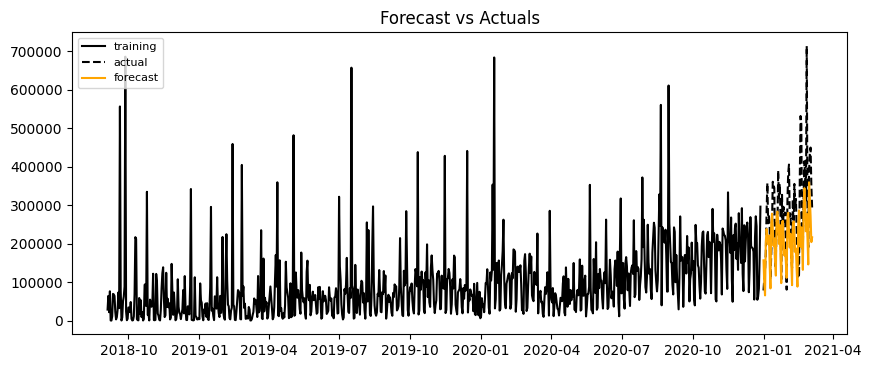

In [159]:
# Plotting 
plot_forecast(best_forecast_recons, train_recons, test_recons, upper = best_upper_recons, lower=best_lower_recons)


In [160]:
# computing mae
best_sarima_performance = pd.DataFrame(test_recons)
best_sarima_performance['best_forecast_recons'] = best_forecast_recons
best_sarima_performance.rename(columns={0: 'test_recons'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['test_recons'] - best_sarima_performance['best_forecast_recons'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()



88452.7291999097

In [ ]:
# Reducing test split does not improve performance

### Additional analysis made with Tomi

Text(0.5, 1.0, '7th Order Differencing')

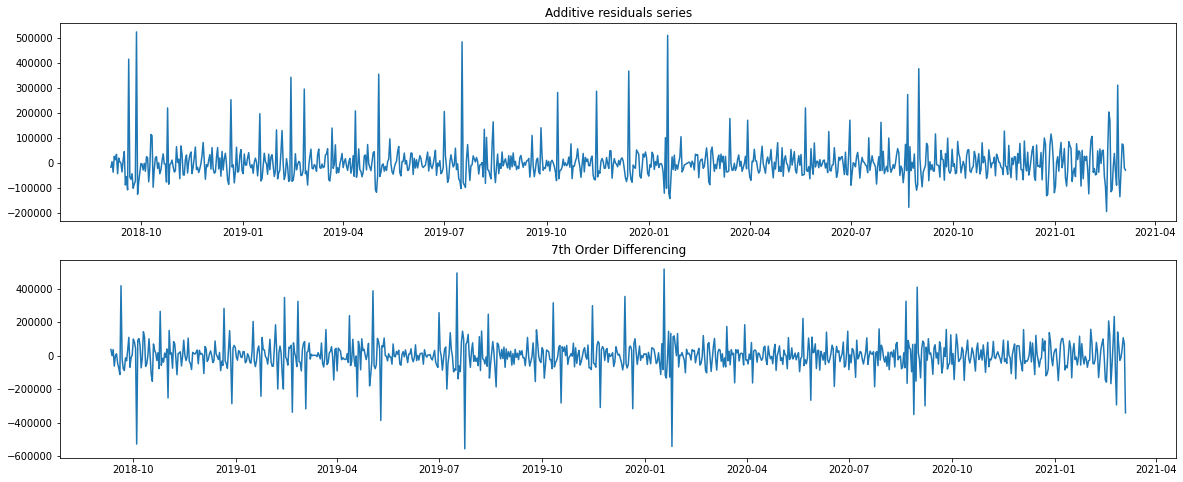

In [161]:


# Differencing additive residuals series by 7 since there seems to be weekly seasonality
add_resid_ts_diff_7 = add_resid_ts.diff(7).dropna()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
ax1.plot(add_resid_ts); ax1.set_title('Additive residuals series')
ax2.plot(add_resid_ts_diff_7); ax2.set_title('7th Order Differencing')


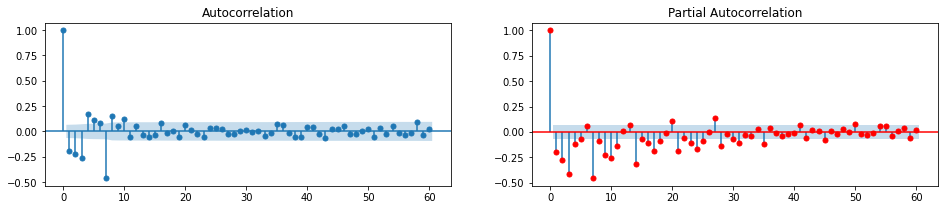

In [162]:
# Checking additive residuals diff 7 ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(add_resid_ts_diff_7, lags=60, ax=axes[0]);
plot_pacf(add_resid_ts_diff_7, lags=60, ax=axes[1], color='r');

### Checking forecast with raw data (w/ Renan)

In [163]:
# Splitting data
# raw serie
split = 0.7
split_index = round(len(data_di)*split)
raw_train = data_di.iloc[:split_index]
raw_test = data_di.iloc[split_index:]


In [164]:
# Trying Auto ARIMA with raw data
stepwise_fit_raw = pm.auto_arima(raw_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_raw.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=16938.519, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=16618.688, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=16310.955, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=16312.943, Time=0.34 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=16312.942, Time=0.54 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=16314.796, Time=0.80 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=16312.616, Time=0.36 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=16298.906, Time=0.32 sec
 ARIMA(0,1,2)(0,1,0)[7]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,2)(1,1,1)[7]             : AIC=16300.893, Time=0.44 sec
 ARIMA(0,1,2)(0,1,2)[7]             : AIC=16300.893, Time=0.74 sec
 ARIMA(0,1,2)(1,1,0)[7]             : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  644
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -8145.453
Date:                             Wed, 10 Mar 2021   AIC                          16298.906
Time:                                     15:05:17   BIC                          16316.727
Sample:                                          0   HQIC                         16305.825
                                             - 644                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9507      0.126     -7.569      0.000      -1.197      -0.705
ma.L2         -0.0331      0.125     -0.265      0.791      -0.278       0.212
ma.S.L7       -0.9258      0.044    -21.128      0.000      -1.012      -0.840
sigma2      1.312e+10   5.91e-12   2.22e+21      0.000    1.31e+10    1.31e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             11636.28
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             3.50
Prob(H) (two-sided):                  0.19   Kurtosis:                        22.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.39e+37. Standard errors may be unstable.
"""

In [165]:
# m=1, AIC = 16354.856, Best model:  ARIMA(2,1,3)(0,0,0)[0]
# m=7, AIC = 16298.906, Best model:  ARIMA(0,1,2)(0,1,1)[7] 

In [166]:
# Build model
sarima = SARIMAX(raw_train, order=(2, 1, 0),seasonal_order=(2,1,2,7))
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(raw_test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [167]:
confidence_int

,lower total_amount_claims,upper total_amount_claims
2020-06-06,-1.739976e+05,2.959059e+05
2020-06-07,-2.208900e+05,2.752137e+05
2020-06-08,-1.786095e+05,3.605107e+05
2020-06-09,-2.148400e+05,3.918752e+05
2020-06-10,-2.278336e+05,4.164603e+05
...,...,...
2021-03-04,-4.741694e+06,4.991125e+06
2021-03-05,-4.774783e+06,4.997879e+06
2021-03-06,-4.851255e+06,4.964115e+06
2021-03-07,-4.895375e+06,4.960496e+06


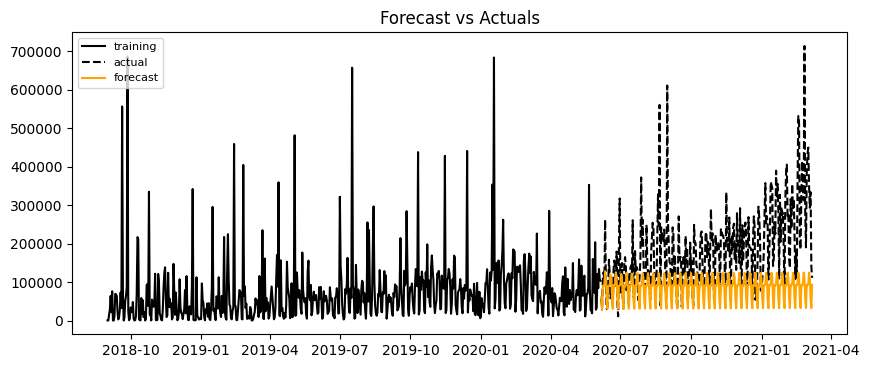

In [168]:
# Plotting

plot_forecast(forecast, raw_train, raw_test, upper = confidence_int['upper total_amount_claims'], lower=confidence_int['lower total_amount_claims'])
